In [2]:
import numpy as np 
import pandas as pd 
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

import urllib.request
import json 
import requests 
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
from scipy import stats

from sklearn.cluster import KMeans

import folium # map rendering library
from branca.colormap import linear

#import cbsodata       # uncomment this if you want to retrieve the neighborhood info through the CBS API

# Foursquare credentials
CLIENT_ID = 'your id here' # your Foursquare ID
CLIENT_SECRET = 'your client secret here' # your Foursquare Secret
VERSION = '20200326'


# Retrieve socio-economic information on neighborhoods in The Hague 

In [3]:
# Retrieve information on neighborhoods in The Hague from the national statistics office
# be sure to install & import cbsodata
# data = pd.DataFrame(cbsodata.get_data('84583NED'))

# So that you dont have to install the cbsodata package, I have doenloaded the following file from the CBS website:
file_to_open = 'https://github.com/jevee/Coursera_Capstone/raw/master/data/Kerncijfers_wijken_en_buurten_2019_22032020_165940.csv'
th_info = pd.read_csv(file_to_open, sep=';')
th_info.head()

Wijken en buurten       Regioaanduiding/Gemeentenaam (naam)  \
0          's-Gravenhage  's-Gravenhage                              
1     Wijk 01 Oostduinen  's-Gravenhage                              
2             Oostduinen  's-Gravenhage                              
3  Wijk 02 Belgisch Park  's-Gravenhage                              
4          Belgisch Park  's-Gravenhage                              

  Regioaanduiding/Soort regio (omschrijving) Regioaanduiding/Codering (code)  \
0                                 Gemeente                        GM0518       
1                                 Wijk                            WK051801     
2                                 Buurt                           BU05180170   
3                                 Wijk                            WK051802     
4                                 Buurt                           BU05180271   

  Regioaanduiding/Indelingswijziging wijken en buurten (code)  \
0                                                  .            
1                                                  1            
2                                                  1            
3                                                  1            
4                                                  1            

   Bevolking/Aantal inwoners (aantal)  Bevolking/Geslacht/Mannen (aantal)  \
0                              537833                              266778   
1                                   0                                   0   
2                                   0                                   0   
3                                8245                                4035   
4                                8245                                4035   

   Bevolking/Geslacht/Vrouwen (aantal)  \
0                               271055   
1                                    0   
2                                    0   
3                                 4210   
4                                 4210   

   Bevolking/Leeftijdsgroepen/0 tot 15 jaar (aantal)  \
0                                              92532   
1                                                  0   
2                                                  0   
3                                               1230   
4                                               1230   

   Bevolking/Leeftijdsgroepen/15 tot 25 jaar (aantal)  ...  \
0                                              66099   ...   
1                                                  0   ...   
2                                                  0   ...   
3                                               1210   ...   
4                                               1210   ...   

   Nabijheid voorzieningen/Afstand tot kinderdagverblijf (km)  \
0                                                  .            
1                                                  .            
2                                                  .            
3                                                  .            
4                                                  .            

   Nabijheid voorzieningen/Basisonderwijs/Afstand tot school (km)  \
0                                                  .                
1                                                  .                
2                                                  .                
3                                                  .                
4                                                  .                

   Nabijheid voorzieningen/Basisonderwijs/Scholen binnen 3 km (aantal)  \
0                                                  .                     
1                                                  .                     
2                                                  .                     
3                                                  .                     
4                                                  .                     

   Oppervlakte/Oppervlakte totaal (ha

In [4]:
#107 columns!!!
th_info.shape

(159, 107)

In [5]:
th_info.columns.values
 

array(['Wijken en buurten', 'Regioaanduiding/Gemeentenaam (naam)',
       'Regioaanduiding/Soort regio (omschrijving)',
       'Regioaanduiding/Codering (code)',
       'Regioaanduiding/Indelingswijziging wijken en buurten (code)',
       'Bevolking/Aantal inwoners (aantal)',
       'Bevolking/Geslacht/Mannen (aantal)',
       'Bevolking/Geslacht/Vrouwen (aantal)',
       'Bevolking/Leeftijdsgroepen/0 tot 15 jaar (aantal)',
       'Bevolking/Leeftijdsgroepen/15 tot 25 jaar (aantal)',
       'Bevolking/Leeftijdsgroepen/25 tot 45 jaar (aantal)',
       'Bevolking/Leeftijdsgroepen/45 tot 65 jaar (aantal)',
       'Bevolking/Leeftijdsgroepen/65 jaar of ouder (aantal)',
       'Bevolking/Burgerlijke staat/Ongehuwd (aantal)',
       'Bevolking/Burgerlijke staat/Gehuwd (aantal)',
       'Bevolking/Burgerlijke staat/Gescheiden (aantal)',
       'Bevolking/Burgerlijke staat/Verweduwd (aantal)',
       'Bevolking/Personen met een migratieachtergrond/Westers totaal (aantal)',
       'Bevolking/Pe

In [6]:
# Lets keep only the following socio-economic columns
# Average House Price (xEUR 1,000)
# % of Homes built after the year 2000 
# The degree of urbanisation, defined as the number of adresses per km2
# surface area of the neighboorhood in 'hectare' (100 x 100 meters)

th_info = th_info[['Wijken en buurten', 'Regioaanduiding/Codering (code)', 'Wonen/Gemiddelde woningwaarde (x 1 000 euro)', 'Wonen/Woningen naar bouwjaar/Bouwjaar vanaf 2000 (%)','Stedelijkheid/Omgevingsadressendichtheid (per km²)', 'Oppervlakte/Oppervlakte totaal (ha)']]
th_info.columns = ['areaName', 'areaCode', 'avgHousePrice', 'pctHousesBuiltAfter2000', 'urbanisationIndex', 'surfaceArea']
th_info

areaName    areaCode avgHousePrice pctHousesBuiltAfter2000  \
0            's-Gravenhage  GM0518               241                      17   
1       Wijk 01 Oostduinen  WK051801               .                       .   
2               Oostduinen  BU05180170             .                       .   
3    Wijk 02 Belgisch Park  WK051802             370                       1   
4            Belgisch Park  BU05180271           370                       1   
..                     ...         ...           ...                     ...   
154  Wijk 44 Leidschenveen  WK051844             345                      92   
155               De Lanen  BU05184418           349                      98   
156              De Velden  BU05184419           339                      79   
157              De Vissen  BU05184420           333                      94   
158              Rietbuurt  BU05184421           387                      98   

     urbanisationIndex  surfaceArea  
0                 4892         9813  
1                  680          318  
2                  680          318  
3                 2474          106  
4                 2474          106  
..                 ...          ...  
154               1461          376  
155               1414           70  
156               1481           75  
157               1454          129  
158               1543          102  

[159 rows x 6 columns]

In [7]:
# replace the dots with nan and check for missing value
th_info = th_info.replace(to_replace="       .", value=np.nan)
th_info.isnull().sum().sort_values(ascending=False)
th_info.shape

(159, 6)

In [8]:
# Delete the rows with incomplete information
th_info.dropna(how='any', axis=0, inplace=True)
th_info.shape


(150, 6)

In [9]:
# Extract the areaname
th_info['areaName'] = th_info['areaName'].str[8:]

# there are spaces after the areaCode, which we remove:
th_info['areaCode'] = th_info['areaCode'].str[:8]

th_info.avgHousePrice = th_info.avgHousePrice.astype('float')

# calculate the distance from the midpoint to the nearest point on the outer border of the neighborhoods
# note that this assumes that the neighboorhoods are perfect squares - of course they are not, but at least we have 
th_info['mid_to_outer'] = 0.5 * np.sqrt(10000*th_info['surfaceArea'])

# or assue the neighboorhoods are circle shaped:
from math import pi
th_info['radius'] = np.sqrt(10000*th_info['surfaceArea']) / pi 

th_info.head()

areaName  areaCode  avgHousePrice  \
0                       nhage  GM0518            241.0   
3               Belgisch Park  WK051802          370.0   
4                        Park  BU051802          370.0   
5  Westbroekpark en Duttendel  WK051803          704.0   
6                       kpark  BU051803          684.0   

  pctHousesBuiltAfter2000  urbanisationIndex  surfaceArea  mid_to_outer  \
0                      17               4892         9813   4953.029376   
3                       1               2474          106    514.781507   
4                       1               2474          106    514.781507   
5                       9               1670          179    668.954408   
6                      17               2386           46    339.116499   

        radius  
0  3153.196434  
3   327.720086  
4   327.720086  
5   425.869603  
6   215.888268

In [10]:
# We will be working wih neighboorhood data (all areacodes starting with 'WK'):
th_district_info = th_info[th_info['areaCode'].str.match('WK')]
th_district_info.set_index('areaCode')

th_district_info.dtypes

areaName                    object
areaCode                    object
avgHousePrice              float64
pctHousesBuiltAfter2000     object
urbanisationIndex            int64
surfaceArea                  int64
mid_to_outer               float64
radius                     float64
dtype: object

# Add location data

In [11]:
# The Hague neighborhood co-ordinates can be downloaded from the following open data platform:
# https://ckan.dataplatform.nl/dataset/c1059cef-be66-4a7a-9657-2f38f55794ed/resource/a175afe5-67e2-4e45-8b71-62f30377bf7d/download/wijken.json
# a copy of which is in the Github project data directory#:

url='https://ckan.dataplatform.nl/dataset/c1059cef-be66-4a7a-9657-2f38f55794ed/resource/a175afe5-67e2-4e45-8b71-62f30377bf7d/download/wijken.json'

# in case the above url doesn't work, comment it out & uncomment the following:
#url = "https://raw.githubusercontent.com/jevee/Coursera_Capstone/master/data/wijken.json"

jsonurl = urllib.request.urlopen(url)
th_hood_geo_json = json.loads(jsonurl.read())

# # uncomment the next line to explore the json file (commented out since it is otherwise printed in its entirety in Github)
# th_hood_geo_json

In [12]:
# when trying to find out why mt chloropleth maps always stayed empty I stumbled upon geopandas
# This turns out to be a very versatile, easy to use way of dealing with geodata.
# Open geodata json as a geodataframe

import geopandas
th_gdf = geopandas.read_file('wijken.json')
th_gdf.head()


WIJKBUURTCODE BUURTCODE               BUURTNAAM WIJKCODE  OCE_ID  \
0          18006        06            Waldeck-Zuid       18     105   
1           9007        07          Statenkwartier        9     105   
2           7001        01        Oud Scheveningen        7     105   
3           7002        02            Vissershaven        7     105   
4           7003        03  Scheveningen Badplaats        7     105   

      DATUMINGANG DATUMVERVALLEN   OPPERVLAKTE       OMTREK  \
0  99990101000000           None  2.081909e+05  1921.728018   
1  99990101000000           None  1.012293e+06  4815.501112   
2  99990101000000           None  2.567414e+05  2516.833623   
3  99990101000000           None  1.179183e+06  5708.949083   
4  99990101000000           None  5.051831e+05  3283.392351   

                                            geometry  
0  POLYGON ((75455.052 452827.067, 75456.657 4528...  
1  POLYGON ((78461.679 456902.171, 78461.770 4569...  
2  POLYGON ((78231.290 457994.778, 78223.217 4579...  
3  POLYGON ((77191.007 457958.836, 77294.732 4575...  
4  POLYGON ((78487.179 458299.457, 78464.483 4582...

In [13]:
# Construct area code to enable mapping to the neighboorhood information retrieved from the Statistics Bureau
th_gdf['AREACODE'] = 'WK0518'+ th_gdf['WIJKCODE'].str.zfill(2)

th_gdf.set_index('AREACODE')
th_gdf.head()

WIJKBUURTCODE BUURTCODE               BUURTNAAM WIJKCODE  OCE_ID  \
0          18006        06            Waldeck-Zuid       18     105   
1           9007        07          Statenkwartier        9     105   
2           7001        01        Oud Scheveningen        7     105   
3           7002        02            Vissershaven        7     105   
4           7003        03  Scheveningen Badplaats        7     105   

      DATUMINGANG DATUMVERVALLEN   OPPERVLAKTE       OMTREK  \
0  99990101000000           None  2.081909e+05  1921.728018   
1  99990101000000           None  1.012293e+06  4815.501112   
2  99990101000000           None  2.567414e+05  2516.833623   
3  99990101000000           None  1.179183e+06  5708.949083   
4  99990101000000           None  5.051831e+05  3283.392351   

                                            geometry  AREACODE  
0  POLYGON ((75455.052 452827.067, 75456.657 4528...  WK051818  
1  POLYGON ((78461.679 456902.171, 78461.770 4569...  WK051809  
2  POLYGON ((78231.290 457994.778, 78223.217 4579...  WK051807  
3  POLYGON ((77191.007 457958.836, 77294.732 4575...  WK051807  
4  POLYGON ((78487.179 458299.457, 78464.483 4582...  WK051807

In [14]:
# the geodata distinguishes between many neighboorhoods, which go a level deeper than Areacode
# lets aggregate to a higher level that matches the neighboods of the ststistics file
# we need only area code and geometry
th_gdf = th_gdf[['AREACODE', 'geometry']]
th_gdf = th_gdf.dissolve(by='AREACODE')        # a geopandas method specifically for this purpose

# add areaname to geodataframe
temp = th_district_info[['areaCode', 'areaName']]
th_gdf = th_gdf.merge(temp, left_on='AREACODE', right_on= 'areaCode')

th_gdf.head()


geometry  areaCode  \
0  POLYGON ((79275.051 459063.730, 79271.595 4590...  WK051802   
1  POLYGON ((79952.366 458256.306, 79969.184 4582...  WK051803   
2  POLYGON ((82022.962 456169.701, 82016.275 4561...  WK051804   
3  POLYGON ((80075.168 456289.937, 80062.209 4562...  WK051805   
4  POLYGON ((79210.104 457434.192, 79212.905 4574...  WK051806   

                           areaName  
0                     Belgisch Park  
1        Westbroekpark en Duttendel  
2                     Benoordenhout  
3                     Archipelbuurt  
4  Van Stolkpark en Scheveningse Bo

# Graphically examining the date
## Visualising the distribution of average house price & degree of urbanisation throughout the city

In [15]:
# Make chloropleth maps for:
#     map 1. 'avgHousePrice'
#     map 2. 'urbanisationIndex'


# show distribution of house prices across the various neighboorhoods of The Hague
# choices for colormapping:
# 'BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'RdPu','YlGn', 'YlGnBu', 'YlOrBr','YlOrRd'

mapHousePrice = folium.Map([52.07, 4.3], zoom_start=12)

folium.Choropleth(
    geo_data=th_gdf,
    data=th_district_info,
    columns=['areaCode','avgHousePrice'],
    key_on='feature.properties.areaCode',
    fill_color='OrRd',
    legend_name='Average house prices xEUR 1,000',
    fill_opacity=0.7,
    line_opacity=0.2,
    highlight=True
).add_to(mapHousePrice)

mapHousePrice

In [16]:
# show degrees of urbanisation across the various neighboorhoods of The Hague

mapUrb = folium.Map([52.07, 4.3], zoom_start=12)


folium.Choropleth(
    geo_data=th_gdf,
    data=th_district_info,
    columns=['areaCode','urbanisationIndex'],
    key_on='feature.properties.areaCode',
    fill_color='BuPu',
    legend_name='Degree of Urbanisation (number of addresses per square kilometer)',
    fill_opacity=0.7,
    line_opacity=0.2,
    highlight=True
).add_to(mapUrb)

mapUrb

# Find the center of each neighborhood

In [17]:
# in the geodataframes, longitudes are shown the 75,000's, instead of between -180 and + 180
# turns out there are multiple co-ordinate systems
# lets check the current one
th_gdf.crs

{'init': 'epsg:28992'}

In [18]:
# We're creating a new geofile, since we will now be looking at co-ordinates (points) rather than areas (polygons)
# change it to conventional lng, lat
# and get the center co-ordinates
th_gdf1 = th_gdf.to_crs({'init': 'epsg:4326'}).copy()
th_gdf1['centroid'] = th_gdf1.centroid
th_gdf1['Longitude'] = th_gdf1.centroid.x
th_gdf1['Latitude'] = th_gdf1.centroid.y
th_gdf1['official_name'] = th_gdf1.geometry.name
th_gdf1.head()

geometry  areaCode  \
0  POLYGON ((4.28164 52.11461, 4.28159 52.11458, ...  WK051802   
1  POLYGON ((4.29171 52.10745, 4.29195 52.10760, ...  WK051803   
2  POLYGON ((4.32237 52.08897, 4.32228 52.08893, ...  WK051804   
3  POLYGON ((4.29393 52.08979, 4.29374 52.08970, ...  WK051805   
4  POLYGON ((4.28106 52.09996, 4.28110 52.09992, ...  WK051806   

                           areaName                  centroid  Longitude  \
0                     Belgisch Park  POINT (4.29236 52.11191)   4.292356   
1        Westbroekpark en Duttendel  POINT (4.30321 52.10403)   4.303211   
2                     Benoordenhout  POINT (4.32134 52.09741)   4.321339   
3                     Archipelbuurt  POINT (4.30271 52.09184)   4.302707   
4  Van Stolkpark en Scheveningse Bo  POINT (4.29148 52.09752)   4.291483   

    Latitude official_name  
0  52.111906      geometry  
1  52.104034      geometry  
2  52.097413      geometry  
3  52.091836      geometry  
4  52.097524      geometry

In [19]:
# Carry on with just lng and lat, drop the rest
th_geo = pd.DataFrame(th_gdf1.drop(columns=['geometry', 'centroid'])).copy()
th_geo.head(10)

areaCode                          areaName  Longitude   Latitude  \
0  WK051802                     Belgisch Park   4.292356  52.111906   
1  WK051803        Westbroekpark en Duttendel   4.303211  52.104034   
2  WK051804                     Benoordenhout   4.321339  52.097413   
3  WK051805                     Archipelbuurt   4.302707  52.091836   
4  WK051806  Van Stolkpark en Scheveningse Bo   4.291483  52.097524   
5  WK051807                      Scheveningen   4.271576  52.103157   
6  WK051808                          Duindorp   4.255054  52.091332   
7  WK051809         Geuzen- en Statenkwartier   4.275138  52.094039   
8  WK051810                         Zorgvliet   4.286192  52.089729   
9  WK051811                          Duinoord   4.281376  52.083595   

  official_name  
0      geometry  
1      geometry  
2      geometry  
3      geometry  
4      geometry  
5      geometry  
6      geometry  
7      geometry  
8      geometry  
9      geometry

# Get venues per neighborhood 

In [20]:
# Re-using the function from the Coursera NY neighborhoods notebook, but adding venue ID

def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            RADIUS, 
            LIMIT)   
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue_ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### The following cell retrieves the venues, make sure your Foursquare credentials are correct
### Alternatively, skip this cell & run the next

In [21]:
LIMIT = 150 # limit of number of venues returned by Foursquare API      Note: seems to be limited to 100 anyways

RADIUS = 500 # define radius

th_venues = getNearbyVenues(names=th_geo['areaName'],
                                   latitudes=th_geo['Latitude'],
                                   longitudes=th_geo['Longitude']
                                  )

KeyError: 'groups'

In [22]:
file_to_open = 'https://github.com/jevee/Coursera_Capstone/raw/master/data/th_venues.xlsx'
th_venues = pd.read_excel(file_to_open)
th_venues.head()

Unnamed: 0   Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0           0  Belgisch Park       5211190568421650        4292355741598000   
1           1  Belgisch Park       5211190568421650        4292355741598000   
2           2  Belgisch Park       5211190568421650        4292355741598000   
3           3  Belgisch Park       5211190568421650        4292355741598000   
4           4  Belgisch Park       5211190568421650        4292355741598000   

                   Venue_ID                  Venue    Venue Latitude  \
0  4db99ea5f7b1b4c54f5568bd               Prosecco          52110887   
1  4d4467780349224b5acdf94e          Bombay Palace          52113994   
2  4c0cd288336220a18eb4c977           Albert Heijn  5211191597209260   
3  4b6069f4f964a52088e429e3  Coffeeshop Blue White   521117361034951   
4  4dbc159ea86e0e98a1d98c2c            Hotel Corel  5211012977452170   

    Venue Longitude        Venue Category  
0           4291525    Italian Restaurant  
1           4286258     Indian Restaurant  
2  4287935527692880           Supermarket  
3  4288645705052730  Marijuana Dispensary  
4  4288078466813540                 Hotel

In [23]:
print("rows in th_venues:", th_venues.shape[0],  '; columns in th_venues:', th_venues.shape[1])
th_venues.head()

rows in th_venues: 782 ; columns in th_venues: 9


Unnamed: 0   Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0           0  Belgisch Park       5211190568421650        4292355741598000   
1           1  Belgisch Park       5211190568421650        4292355741598000   
2           2  Belgisch Park       5211190568421650        4292355741598000   
3           3  Belgisch Park       5211190568421650        4292355741598000   
4           4  Belgisch Park       5211190568421650        4292355741598000   

                   Venue_ID                  Venue    Venue Latitude  \
0  4db99ea5f7b1b4c54f5568bd               Prosecco          52110887   
1  4d4467780349224b5acdf94e          Bombay Palace          52113994   
2  4c0cd288336220a18eb4c977           Albert Heijn  5211191597209260   
3  4b6069f4f964a52088e429e3  Coffeeshop Blue White   521117361034951   
4  4dbc159ea86e0e98a1d98c2c            Hotel Corel  5211012977452170   

    Venue Longitude        Venue Category  
0           4291525    Italian Restaurant  
1           4286258     Indian Restaurant  
2  4287935527692880           Supermarket  
3  4288645705052730  Marijuana Dispensary  
4  4288078466813540                 Hotel

In [24]:
# check for duplicates
th_venues.Venue_ID.value_counts()

51757eb2e4b068d05afaa4dc    1
4b9bd650f964a520542b36e3    1
4bd890f5e914a593fa9853fa    1
4b2e1f49f964a520dddc24e3    1
4c6a9c5c1a6620a1b77d668c    1
                           ..
4c2230779390c9b63e1ecacd    1
4c2ddec7987f20a159144aaa    1
4b81c49df964a520eebc30e3    1
4c0f5b877189c928d5efd9b6    1
4c133687a9c220a18879559d    1
Name: Venue_ID, Length: 782, dtype: int64

In [25]:
# When I last ran it only around 10 duplicates out of around 800 venues, so just drop them rather than investigating further
# Note: if you downloaded the file from the Github project data directory, duplicates have already been removed
th_venues.drop_duplicates(subset ="Venue_ID", keep='first', inplace=True)
th_venues.Venue_ID.value_counts()

51757eb2e4b068d05afaa4dc    1
4b9bd650f964a520542b36e3    1
4bd890f5e914a593fa9853fa    1
4b2e1f49f964a520dddc24e3    1
4c6a9c5c1a6620a1b77d668c    1
                           ..
4c2230779390c9b63e1ecacd    1
4c2ddec7987f20a159144aaa    1
4b81c49df964a520eebc30e3    1
4c0f5b877189c928d5efd9b6    1
4c133687a9c220a18879559d    1
Name: Venue_ID, Length: 782, dtype: int64

In [26]:
th_venues.head()

Unnamed: 0   Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0           0  Belgisch Park       5211190568421650        4292355741598000   
1           1  Belgisch Park       5211190568421650        4292355741598000   
2           2  Belgisch Park       5211190568421650        4292355741598000   
3           3  Belgisch Park       5211190568421650        4292355741598000   
4           4  Belgisch Park       5211190568421650        4292355741598000   

                   Venue_ID                  Venue    Venue Latitude  \
0  4db99ea5f7b1b4c54f5568bd               Prosecco          52110887   
1  4d4467780349224b5acdf94e          Bombay Palace          52113994   
2  4c0cd288336220a18eb4c977           Albert Heijn  5211191597209260   
3  4b6069f4f964a52088e429e3  Coffeeshop Blue White   521117361034951   
4  4dbc159ea86e0e98a1d98c2c            Hotel Corel  5211012977452170   

    Venue Longitude        Venue Category  
0           4291525    Italian Restaurant  
1           4286258     Indian Restaurant  
2  4287935527692880           Supermarket  
3  4288645705052730  Marijuana Dispensary  
4  4288078466813540                 Hotel

In [27]:
th_venues['Venue Category'].value_counts()

Supermarket             38
Restaurant              36
Café                    29
Italian Restaurant      26
Coffee Shop             22
                        ..
Other Great Outdoors     1
Factory                  1
Pie Shop                 1
Mini Golf                1
Shopping Plaza           1
Name: Venue Category, Length: 180, dtype: int64

In [28]:
# venues per neighborhood
th_venues[['Neighborhood', 'Venue']].groupby('Neighborhood').agg('count')

Venue
Neighborhood                           
Archipelbuurt                        18
Belgisch Park                         9
Benoordenhout                         8
Bezuidenhout                         41
Binckhorst                           14
Bohemen en Meer en Bos               11
Bomen- en Bloemenbuurt               30
Bouwlust en Vrederust                 7
Centrum                             100
Duindorp                              6
Duinoord                             27
Geuzen- en Statenkwartier            30
Groente- en Fruitmarkt               16
Haagse Bos                            6
Hoornwijk                             1
Kijkduin en Ockenburgh                8
Kraayenstein en Vroondaal             3
Laakkwartier en Spoorwijk             5
Leidschenveen                        10
Leyenburg                            15
Loosduinen                           11
Mariahoeve en Marlot                  9
Moerwijk                              9
Morgenstond                          31
Regentessekwartier                   20
Rustenburg en Oostbroek              13
Scheveningen                         45
Schildersbuurt                       23
Stationsbuurt                        42
Transvaalkwartier                     3
Valkenboskwartier                     7
Van Stolkpark en Scheveningse Bo     10
Vogelwijk                             2
Vruchtenbuurt                        14
Waldeck                               9
Wateringse Veld                      10
Westbroekpark en Duttendel            6
Willemspark                          63
Ypenburg                              9
Zeeheldenkwartier                    53
Zorgvliet                            15
Zuiderpark                           13

In [29]:
# one hot encoding
th_onehot = pd.get_dummies(th_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
th_onehot['Neighborhood'] = th_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [th_onehot.columns[-1]] + list(th_onehot.columns[:-1])
th_onehot = th_onehot[fixed_columns]

th_onehot.head()

Neighborhood  American Restaurant  Argentinian Restaurant  Art Gallery  \
0  Belgisch Park                    0                       0            0   
1  Belgisch Park                    0                       0            0   
2  Belgisch Park                    0                       0            0   
3  Belgisch Park                    0                       0            0   
4  Belgisch Park                    0                       0            0   

   Art Museum  Asian Restaurant  Athletics & Sports  Auto Workshop  \
0           0                 0                   0              0   
1           0                 0                   0              0   
2           0                 0                   0              0   
3           0                 0                   0              0   
4           0                 0                   0              0   

   Bagel Shop  Bakery  ...  Tram Station  Turkish Restaurant  \
0           0       0  ...             0                   0   
1           0       0  ...             0                   0   
2           0       0  ...             0                   0   
3           0       0  ...             0                   0   
4           0       0  ...             0                   0   

   Vegetarian / Vegan Restaurant  Video Game Store  Video Store  \
0                              0                 0            0   
1                              0                 0            0   
2                              0                 0            0   
3                              0                 0            0   
4                              0                 0            0   

   Vietnamese Restaurant  Wine Bar  Wine Shop  Women's Store  Yoga Studio  
0                      0         0          0              0            0  
1                      0         0          0              0            0  
2                      0         0          0              0            0  
3                      0         0          0              0            0  
4                      0         0          0              0            0  

[5 rows x 181 columns]

In [30]:
th_grouped = th_onehot.groupby('Neighborhood').mean().reset_index()
th_grouped.head()

Neighborhood  American Restaurant  Argentinian Restaurant  Art Gallery  \
0  Archipelbuurt                  0.0                     0.0          0.0   
1  Belgisch Park                  0.0                     0.0          0.0   
2  Benoordenhout                  0.0                     0.0          0.0   
3   Bezuidenhout                  0.0                     0.0          0.0   
4     Binckhorst                  0.0                     0.0          0.0   

   Art Museum  Asian Restaurant  Athletics & Sports  Auto Workshop  \
0         0.0          0.055556                 0.0            0.0   
1         0.0          0.000000                 0.0            0.0   
2         0.0          0.000000                 0.0            0.0   
3         0.0          0.048780                 0.0            0.0   
4         0.0          0.000000                 0.0            0.0   

   Bagel Shop    Bakery  ...  Tram Station  Turkish Restaurant  \
0         0.0  0.055556  ...      0.055556             0.00000   
1         0.0  0.000000  ...      0.000000             0.00000   
2         0.0  0.000000  ...      0.000000             0.00000   
3         0.0  0.048780  ...      0.000000             0.04878   
4         0.0  0.071429  ...      0.000000             0.00000   

   Vegetarian / Vegan Restaurant  Video Game Store  Video Store  \
0                            0.0               0.0          0.0   
1                            0.0               0.0          0.0   
2                            0.0               0.0          0.0   
3                            0.0               0.0          0.0   
4                            0.0               0.0          0.0   

   Vietnamese Restaurant  Wine Bar  Wine Shop  Women's Store  Yoga Studio  
0                0.00000       0.0   0.055556            0.0          0.0  
1                0.00000       0.0   0.000000            0.0          0.0  
2                0.00000       0.0   0.000000            0.0          0.0  
3                0.02439       0.0   0.000000            0.0          0.0  
4                0.00000       0.0   0.000000            0.0          0.0  

[5 rows x 181 columns]

In [31]:
# reduce the numer of features by grouping eateries together as a single category/ column

Restaurants= list(th_grouped.loc[:, th_grouped.columns.str.contains("Restaurant|Deli|Brasserie|Diner")])
Restaurants.remove('Fast Food Restaurant') #will be in next group
FastFood= list(th_grouped.loc[:, th_grouped.columns.str.contains("Snack Place|Fast Food|Burrito|Pizza|Burger")])
Pubs= list(th_grouped.loc[:, th_grouped.columns.str.contains("Pub|Bar")])

th_grouped['Restaurants'] = th_grouped[Restaurants].sum(axis=1)
th_grouped['FastFood'] = th_grouped[FastFood].sum(axis=1)
th_grouped['Pubs'] = th_grouped[FastFood].sum(axis=1)
toDrop = Restaurants + FastFood + Pubs
th_grouped = th_grouped.drop(toDrop, 1) 
th_grouped.head()

Neighborhood  Art Gallery  Art Museum  Athletics & Sports  Auto Workshop  \
0  Archipelbuurt          0.0         0.0                 0.0            0.0   
1  Belgisch Park          0.0         0.0                 0.0            0.0   
2  Benoordenhout          0.0         0.0                 0.0            0.0   
3   Bezuidenhout          0.0         0.0                 0.0            0.0   
4     Binckhorst          0.0         0.0                 0.0            0.0   

   Bagel Shop    Bakery  Baseball Field  Beach  Bed & Breakfast  ...  \
0         0.0  0.055556             0.0    0.0         0.000000  ...   
1         0.0  0.000000             0.0    0.0         0.111111  ...   
2         0.0  0.000000             0.0    0.0         0.000000  ...   
3         0.0  0.048780             0.0    0.0         0.000000  ...   
4         0.0  0.071429             0.0    0.0         0.000000  ...   

   Train Station  Tram Station  Video Game Store  Video Store  Wine Shop  \
0       0.000000      0.055556               0.0          0.0   0.055556   
1       0.000000      0.000000               0.0          0.0   0.000000   
2       0.000000      0.000000               0.0          0.0   0.000000   
3       0.000000      0.000000               0.0          0.0   0.000000   
4       0.071429      0.000000               0.0          0.0   0.000000   

   Women's Store  Yoga Studio  Restaurants  FastFood      Pubs  
0            0.0          0.0     0.333333  0.055556  0.055556  
1            0.0          0.0     0.333333  0.000000  0.000000  
2            0.0          0.0     0.000000  0.000000  0.000000  
3            0.0          0.0     0.341463  0.048780  0.048780  
4            0.0          0.0     0.214286  0.071429  0.071429  

[5 rows x 134 columns]

# Clustering to see which neighborhoods share similar characteristics

In [32]:
# set number of clusters
kclusters = 8   
th_grouped_clustering = th_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(th_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:50] 

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 5, 0, 0, 0, 0, 6, 1, 2, 7, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 5, 5, 1, 3, 1, 4, 1, 1, 0, 0, 0, 1, 1],
      dtype=int32)

In [33]:
# add clustering labels
th_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
th_merged = th_geo.merge(th_grouped, how = 'left', left_on='areaName', right_on = 'Neighborhood')

# remove NaN 
th_merged.dropna(how='any', inplace=True) # check the last columns for NaN!


In [34]:
# Indspect individual clusters (change Cluster Label)
th_merged.loc[th_merged['Cluster Labels'] == 0, th_merged.columns[[1] + list(range(5, th_merged.shape[1]))]]


areaName  Cluster Labels               Neighborhood  \
0               Belgisch Park               0              Belgisch Park   
3               Archipelbuurt               0              Archipelbuurt   
5                Scheveningen               0               Scheveningen   
7   Geuzen- en Statenkwartier               0  Geuzen- en Statenkwartier   
9                    Duinoord               0                   Duinoord   
10     Bomen- en Bloemenbuurt               0     Bomen- en Bloemenbuurt   
19         Regentessekwartier               0         Regentessekwartier   
20          Zeeheldenkwartier               0          Zeeheldenkwartier   
21                Willemspark               0                Willemspark   
22                 Haagse Bos               0                 Haagse Bos   
24               Bezuidenhout               0               Bezuidenhout   
25              Stationsbuurt               0              Stationsbuurt   
26                    Centrum               0                    Centrum   
27             Schildersbuurt               0             Schildersbuurt   
29    Rustenburg en Oostbroek               0    Rustenburg en Oostbroek   
35     Groente- en Fruitmarkt               0     Groente- en Fruitmarkt   
37                 Binckhorst               0                 Binckhorst   
40                   Ypenburg               0                   Ypenburg   

    Art Gallery  Art Museum  Athletics & Sports  Auto Workshop  Bagel Shop  \
0      0.000000    0.000000                 0.0            0.0    0.000000   
3      0.000000    0.000000                 0.0            0.0    0.000000   
5      0.000000    0.000000                 0.0            0.0    0.000000   
7      0.000000    0.000000                 0.0            0.0    0.000000   
9      0.000000    0.000000                 0.0            0.0    0.000000   
10     0.000000    0.000000                 0.0            0.0    0.033333   
19     0.050000    0.000000                 0.0            0.0    0.000000   
20     0.000000    0.018868                 0.0            0.0    0.018868   
21     0.015873    0.015873                 0.0            0.0    0.000000   
22     0.000000    0.000000                 0.0            0.0    0.000000   
24     0.000000    0.000000                 0.0            0.0    0.000000   
25     0.000000    0.000000                 0.0            0.0    0.000000   
26     0.000000    0.010000                 0.0            0.0    0.010000   
27     0.000000    0.000000                 0.0            0.0    0.000000   
29     0.000000    0.000000                 0.0            0.0    0.000000   
35     0.000000    0.000000                 0.0            0.0    0.000000   
37     0.000000    0.000000                 0.0            0.0    0.000000   
40     0.000000    0.000000                 0.0            0.0    0.000000   

      Bakery  Baseball Field  ...  Train Station  Tram Station  \
0   0.000000             0.0  ...       0.000000      0.000000   
3   0.055556             0.0  ...       0.000000      0.055556   
5   0.022222             0.0  ...       0.000000      0.022222   
7   0.066667             0.0  ...       0.000000      0.000000   
9   0.037037             0.0  ...       0.000000      0.000000   
10  0.033333             0.0  ...       0.000000      0.033333   
19  0.000000             0.0  ...       0.000000      0.000000   
20  0.018868             0.0  ...       0.000000      0.000000   
21  0.000000             0.0  ...       0.000000      0.000000   
22  0.000000             0.0  ...       0.000000      0.000000   
24  0.048780             0.0  ...       0.000000      0.000000   
25  0.023810             0.0  ...       0.023810      0.047619   
26  0.020000             0.0  ...       0.000000      0.000000   
27  0.086957             0.0  ...       0.000000      0.043478   
29  0.000000             0.0  ...       0.000000      0.076923   
35  0.062500             0.0  ...    

# Now let's superimpose the clusters on the Cloroplet maps created before

In [35]:
# House prices

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(th_merged['Latitude'], th_merged['Longitude'], th_merged['areaCode'], th_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(mapHousePrice)      # add to chloropleth map
     
mapHousePrice

In [36]:
# Degree of urbanisation

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(th_merged['Latitude'], th_merged['Longitude'], th_merged['areaCode'], th_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(mapUrb)      # add to chloropleth map
     
mapUrb

# Get venue ratings

In [37]:
# create a function to get richer info for each of the venues

def getVenueStats(venue_ids):    
    
    venue_stats=pd.DataFrame()
    
    for venue in venue_ids:
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
            venue,
            CLIENT_ID, 
            CLIENT_SECRET,
            VERSION
            )
        
        results = requests.get(url).json()['response']['venue']
        pd_json = json_normalize(results)
        venue_stats = venue_stats.append(pd_json, ignore_index=True, sort=False)
    return venue_stats


In [38]:
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
            '4bd70a2b304fce72e51233ab',
            CLIENT_ID, 
            CLIENT_SECRET,
            VERSION
            )
        
results = requests.get(url).json()
results

{'meta': {'code': 400,
  'errorType': 'invalid_auth',
  'errorDetail': 'Missing access credentials. See https://developer.foursquare.com/docs/api/configuration/authentication for details.',
  'requestId': '5e937023e826ac001bf09359'},
 'response': {}}

In [39]:
# venue ratings are premium requests
# Foursquare allows only 500 premium requests per day, so we break the set into 2 pieces, with each having less than 500 venues
venue_ids_set1 = th_venues['Venue_ID'][:400]
venue_ids_set2 = th_venues['Venue_ID'][400:]


# The following cell gets the venue details
### It needs to be run for both sets and requires a 24 hour wait in between.
### The data is therefore picked up from the Github project site

In [40]:
# venue_stats_set2 = getVenueStats(venue_ids_set2)
# venue_stats_set2 = getVenueStats(venue_ids_set2)


In [41]:
file_to_open = 'https://github.com/jevee/Coursera_Capstone/raw/master/data/venue_stats_set1.xlsx'
venue_stats1 = pd.read_excel(file_to_open)
venue_stats1.shape

(400, 137)

In [42]:
file_to_open = 'https://github.com/jevee/Coursera_Capstone/raw/master/data/venue_stats_set2.xlsx'
venue_stats2 = pd.read_excel(file_to_open)
venue_stats2.shape

(390, 138)

In [43]:
venue_stats = venue_stats1.append(venue_stats2)
venue_stats.shape

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


(790, 139)

In [44]:
venue_stats.head()

allowMenuUrlEdit                                  attributes.groups  \
0               1.0  [{'type': 'price', 'name': 'Price', 'summary':...   
1               1.0  [{'type': 'price', 'name': 'Price', 'summary':...   
2               1.0  [{'type': 'payments', 'name': 'Credit Cards', ...   
3               1.0                                                 []   
4               1.0                                                 []   

   beenHere.count  beenHere.lastCheckinExpiredAt  beenHere.marked  \
0               0                              0            False   
1               0                              0            False   
2               0                              0            False   
3               0                              0            False   
4               0                              0            False   

   beenHere.unconfirmedCount  bestPhoto.createdAt  bestPhoto.height  \
0                          0         1.450818e+09            1440.0   
1                          0         1.339871e+09             537.0   
2                          0         1.459498e+09            1440.0   
3                          0         1.565468e+09            1920.0   
4                          0         1.465216e+09            1440.0   

               bestPhoto.id                      bestPhoto.prefix  ...  \
0  5679bac3498e8d54198974a6  https://fastly.4sqi.net/img/general/  ...   
1  4fdcce7ee4b0d60dd896520c  https://fastly.4sqi.net/img/general/  ...   
2  56fe2e02498eb29c77368a3b  https://fastly.4sqi.net/img/general/  ...   
3  5d4f24289002c90008423fe3  https://fastly.4sqi.net/img/general/  ...   
4  57556a1a498e12f191adcd70  https://fastly.4sqi.net/img/general/  ...   

  specials.items stats.tipCount storeId          timeZone  tips.count  \
0             []              5     NaN  Europe/Amsterdam           5   
1             []              3     NaN  Europe/Amsterdam           3   
2             []              1     NaN  Europe/Amsterdam           1   
3             []              5     NaN  Europe/Amsterdam           5   
4             []              1     NaN  Europe/Amsterdam           1   

                                         tips.groups               url  \
0  [{'type': 'others', 'name': 'All tips', 'count...               NaN   
1  [{'type': 'others', 'name': 'All tips', 'count...               NaN   
2  [{'type': 'others', 'name': 'All tips', 'count...  http://www.ah.nl   
3  [{'type': 'others', 'name': 'All tips', 'count...               NaN   
4  [{'type': 'others', 'name': 'All tips', 'count...               NaN   

   venuePage.id venueRatingBlacklisted  verified  
0           NaN                    NaN     False  
1           NaN                    NaN     False  
2           NaN                    NaN     False  
3           NaN                    NaN     False  
4           NaN                    NaN     False  

[5 rows x 139 columns]

In [45]:
# Keep only rating column
venue_stats = venue_stats[['id', 'rating']].copy()
venue_stats.dropna(how='any', axis=0, inplace=True)
venue_stats

id  rating
0    4db99ea5f7b1b4c54f5568bd     7.5
1    4d4467780349224b5acdf94e     7.4
2    4c0cd288336220a18eb4c977     6.4
3    4b6069f4f964a52088e429e3     6.1
4    4dbc159ea86e0e98a1d98c2c     5.9
..                        ...     ...
373  4c7f855afb13a1cd75b9a0a4     6.3
378  4b9c3925f964a520865636e3     7.5
379  5260102111d21567f62bd8f3     6.9
380  4b9cc7bdf964a520407b36e3     6.4
381  4da6161690a0056063248453     5.9

[527 rows x 2 columns]

In [46]:
neigh_ven_quality = venue_stats.merge(th_venues, how = 'left', left_on='id', right_on = 'Venue_ID')
neigh_ven_quality

id  rating  Unnamed: 0   Neighborhood  \
0    4db99ea5f7b1b4c54f5568bd     7.5         0.0  Belgisch Park   
1    4d4467780349224b5acdf94e     7.4         1.0  Belgisch Park   
2    4c0cd288336220a18eb4c977     6.4         2.0  Belgisch Park   
3    4b6069f4f964a52088e429e3     6.1         3.0  Belgisch Park   
4    4dbc159ea86e0e98a1d98c2c     5.9         4.0  Belgisch Park   
..                        ...     ...         ...            ...   
522  4c7f855afb13a1cd75b9a0a4     6.3       777.0       Ypenburg   
523  4b9c3925f964a520865636e3     7.5       783.0  Leidschenveen   
524  5260102111d21567f62bd8f3     6.9       784.0  Leidschenveen   
525  4b9cc7bdf964a520407b36e3     6.4       785.0  Leidschenveen   
526  4da6161690a0056063248453     5.9       786.0  Leidschenveen   

     Neighborhood Latitude  Neighborhood Longitude                  Venue_ID  \
0             5.211191e+15            4.292356e+15  4db99ea5f7b1b4c54f5568bd   
1             5.211191e+15            4.292356e+15  4d4467780349224b5acdf94e   
2             5.211191e+15            4.292356e+15  4c0cd288336220a18eb4c977   
3             5.211191e+15            4.292356e+15  4b6069f4f964a52088e429e3   
4             5.211191e+15            4.292356e+15  4dbc159ea86e0e98a1d98c2c   
..                     ...                     ...                       ...   
522           5.204175e+15            4.373357e+15  4c7f855afb13a1cd75b9a0a4   
523           5.206239e+16            4.406197e+15  4b9c3925f964a520865636e3   
524           5.206239e+16            4.406197e+15  5260102111d21567f62bd8f3   
525           5.206239e+16            4.406197e+15  4b9cc7bdf964a520407b36e3   
526           5.206239e+16            4.406197e+15  4da6161690a0056063248453   

                     Venue  Venue Latitude  Venue Longitude  \
0                 Prosecco    5.211089e+07     4.291525e+06   
1            Bombay Palace    5.211399e+07     4.286258e+06   
2             Albert Heijn    5.211192e+15     4.287936e+15   
3    Coffeeshop Blue White    5.211174e+14     4.288646e+15   
4              Hotel Corel    5.211013e+15     4.288078e+15   
..                     ...             ...              ...   
522               Kruidvat    5.204184e+16     4.370460e+15   
523           Albert Heijn    5.206469e+15     4.401899e+15   
524                SUBWAY®    5.206547e+15     4.401699e+15   
525                   HEMA    5.206532e+16     4.402405e+15   
526           't Hoge Veen    5.206482e+15     4.402331e+15   

           Venue Category  
0      Italian Restaurant  
1       Indian Restaurant  
2             Supermarket  
3    Marijuana Dispensary  
4                   Hotel  
..                    ...  
522             Drugstore  
523           Supermarket  
524        Sandwich Place  
525      Department Store  
526         Shopping Mall  

[527 rows x 11 columns]

In [47]:
neigh_ven_quality = neigh_ven_quality[['Neighborhood', 'rating']].groupby('Neighborhood').agg(
    rating_mean = pd.NamedAgg(column='rating', aggfunc = 'mean'),
    rating_count = pd.NamedAgg(column='rating', aggfunc = 'count')
    )
neigh_ven_quality.reset_index(inplace=True)
neigh_ven_quality


Neighborhood  rating_mean  rating_count
0                      Archipelbuurt     6.975000            12
1                      Belgisch Park     6.660000             5
2                      Benoordenhout     7.533333             3
3                       Bezuidenhout     6.988571            35
4                         Binckhorst     7.466667             6
5             Bohemen en Meer en Bos     7.333333             3
6             Bomen- en Bloemenbuurt     7.311765            17
7                            Centrum     8.239175            97
8                           Duindorp     8.100000             3
9                           Duinoord     7.354545            22
10         Geuzen- en Statenkwartier     7.515385            26
11            Groente- en Fruitmarkt     6.400000             1
12                        Haagse Bos     7.500000             3
13            Kijkduin en Ockenburgh     6.975000             4
14         Laakkwartier en Spoorwijk     7.950000             2
15                     Leidschenveen     6.675000             4
16                         Leyenburg     7.050000             2
17                        Loosduinen     6.516667             6
18              Mariahoeve en Marlot     6.916667             6
19                       Morgenstond     6.300000             8
20                Regentessekwartier     7.452941            17
21           Rustenburg en Oostbroek     6.800000             7
22                      Scheveningen     7.300000            32
23                    Schildersbuurt     7.050000            10
24                     Stationsbuurt     7.500000            40
25                 Transvaalkwartier     6.566667             3
26                 Valkenboskwartier     6.560000             5
27  Van Stolkpark en Scheveningse Bo     8.075000             4
28                     Vruchtenbuurt     7.300000             4
29                           Waldeck     7.200000             1
30                   Wateringse Veld     6.125000             4
31        Westbroekpark en Duttendel     7.200000             2
32                       Willemspark     7.453846            65
33                          Ypenburg     6.800000             4
34                 Zeeheldenkwartier     7.471111            45
35                         Zorgvliet     7.741667            12
36                        Zuiderpark     6.600000             4

In [48]:
mapRatings = folium.Map([52.07, 4.3], zoom_start=12)

folium.Choropleth(
    geo_data=th_gdf,
    data=neigh_ven_quality,
    columns=['Neighborhood','rating_mean'],
    key_on='feature.properties.areaName',
    fill_color='YlGn',
    legend_name='Average venue rating',
    fill_opacity=0.7,
    line_opacity=0.2,
    highlight=True
).add_to(mapRatings)

mapRatings

In [49]:
neigh_stats = neigh_ven_quality.merge(th_district_info, how = 'left', left_on='Neighborhood', right_on = 'areaName').copy()
neigh_stats.reset_index(inplace=True)
neigh_stats.head()

index   Neighborhood  rating_mean  rating_count       areaName  areaCode  \
0      0  Archipelbuurt     6.975000            12  Archipelbuurt  WK051805   
1      1  Belgisch Park     6.660000             5  Belgisch Park  WK051802   
2      2  Benoordenhout     7.533333             3  Benoordenhout  WK051804   
3      3   Bezuidenhout     6.988571            35   Bezuidenhout  WK051826   
4      4     Binckhorst     7.466667             6     Binckhorst  WK051839   

   avgHousePrice pctHousesBuiltAfter2000  urbanisationIndex  surfaceArea  \
0          506.0                       6               3269           87   
1          370.0                       1               2474          106   
2          503.0                       2               2070          274   
3          263.0                      14               4202          193   
4          188.0                      56               3474          146   

   mid_to_outer      radius  
0    466.368953  296.899696  
1    514.781507  327.720086  
2    827.647268  526.896615  
3    694.622199  442.210227  
4    604.152299  384.615299

In [50]:
neigh_stats = neigh_stats[['Neighborhood', 'rating_mean', 'rating_count', 'avgHousePrice', 'urbanisationIndex']]
neigh_stats.head()

Neighborhood  rating_mean  rating_count  avgHousePrice  urbanisationIndex
0  Archipelbuurt     6.975000            12          506.0               3269
1  Belgisch Park     6.660000             5          370.0               2474
2  Benoordenhout     7.533333             3          503.0               2070
3   Bezuidenhout     6.988571            35          263.0               4202
4     Binckhorst     7.466667             6          188.0               3474

In [51]:
neigh_stats.dtypes

Neighborhood          object
rating_mean          float64
rating_count           int64
avgHousePrice        float64
urbanisationIndex      int64
dtype: object

(0, 822.3141255460356)

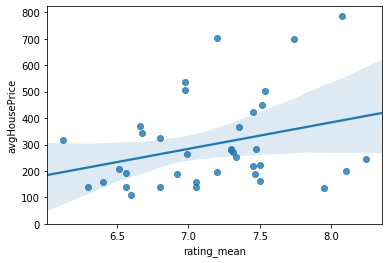

In [52]:
sns.regplot(x="rating_mean", y="avgHousePrice", data=neigh_stats)
plt.ylim(0,)

(0, 8804.002152690771)

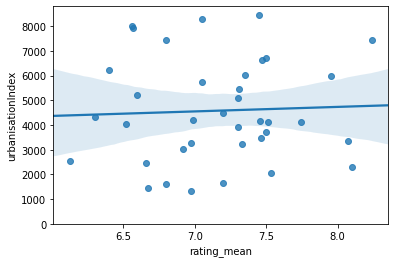

In [53]:
sns.regplot(x="rating_mean", y="urbanisationIndex", data=neigh_stats)
plt.ylim(0,)

In [54]:
neigh_stats.corr()

rating_mean  rating_count  avgHousePrice  urbanisationIndex
rating_mean           1.000000      0.410238       0.301763           0.045588
rating_count          0.410238      1.000000       0.005702           0.304265
avgHousePrice         0.301763      0.005702       1.000000          -0.522527
urbanisationIndex     0.045588      0.304265      -0.522527           1.000000

In [55]:
pearson_coef, p_value = stats.pearsonr(neigh_stats['avgHousePrice'], neigh_stats['rating_mean'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)  

The Pearson Correlation Coefficient is 0.30176282114891306  with a P-value of P = 0.06950446279311068


In [56]:
neigh_stats1 = neigh_stats.copy()
neigh_stats1 = neigh_stats1[neigh_stats1.rating_count>5]
neigh_stats1

Neighborhood  rating_mean  rating_count  avgHousePrice  \
0               Archipelbuurt     6.975000            12          506.0   
3                Bezuidenhout     6.988571            35          263.0   
4                  Binckhorst     7.466667             6          188.0   
6      Bomen- en Bloemenbuurt     7.311765            17          272.0   
7                     Centrum     8.239175            97          244.0   
9                    Duinoord     7.354545            22          367.0   
10  Geuzen- en Statenkwartier     7.515385            26          448.0   
17                 Loosduinen     6.516667             6          206.0   
18       Mariahoeve en Marlot     6.916667             6          189.0   
19                Morgenstond     6.300000             8          139.0   
20         Regentessekwartier     7.452941            17          220.0   
21    Rustenburg en Oostbroek     6.800000             7          138.0   
22               Scheveningen     7.300000            32          281.0   
23             Schildersbuurt     7.050000            10          140.0   
24              Stationsbuurt     7.500000            40          161.0   
32                Willemspark     7.453846            65          422.0   
34          Zeeheldenkwartier     7.471111            45          282.0   
35                  Zorgvliet     7.741667            12          700.0   

    urbanisationIndex  
0                3269  
3                4202  
4                3474  
6                5476  
7                7447  
9                6027  
10               4138  
17               4036  
18               3016  
19               4345  
20               8440  
21               7430  
22               3936  
23               8284  
24               6718  
32               4148  
34               6629  
35               4112

(0, 760.4545793187561)

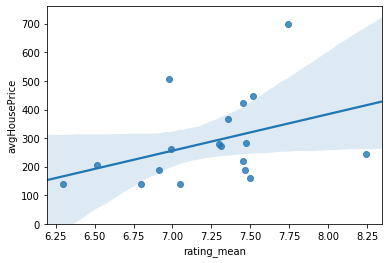

In [57]:
sns.regplot(x="rating_mean", y="avgHousePrice", data=neigh_stats1)
plt.ylim(0,)

In [58]:
pearson_coef, p_value = stats.pearsonr(neigh_stats1['avgHousePrice'], neigh_stats1['rating_mean'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)  

The Pearson Correlation Coefficient is 0.38508733378109467  with a P-value of P = 0.11455021140474007
